## Overview Analysis
![img.png](img/SystemStartUp.png)
![SystemStartupAnalysis.svg](img/SystemStartupAnalysis.svg)

In [49]:
package 'PowerRollUp'{
    import ScalarValues::Real;
    import ScalarFunctions::sum;
    
    import 'RollUpPattern'::*;
    import Behavior::*;
    import Structure::*;
    import Analysis_package::*;
    
    value type Power specializes Real;
    
    
    package 'RollUpPattern' {
        block PowerConstraint {
            
            exhibit state behavior : PRBehavior (
                power_input = power, 
                init_power = initPower, 
                op_power = operatingPower
            );
            
            part subPower : PowerConstraint [*];
            value power : Power = 0.0;
            value operatingPower : Power = 0.0;
            value initPower : Power = 0.0;
            value totalPower : Power = sum(subPower::totalPower) + power;
        }// END PowerConstraint
        
        package Behavior {
            attribute def Done;
            attribute def Init;
            attribute def TurnOff;
            attribute def TurnOn;

            state def 'PRBehavior'(power_input : Power, init_power : Power, op_power : Power) {    
                entry;

                state Off {
//                     still waiting for way to set values
                    assert constraint {power_input == 0}
                }
                transition off_to_initializing
                    first Off
                    accept Init
                    then initializing;
                transition off_to_on
                    first Off
                    accept TurnOn
                    then On;

                state initializing {
                    assert constraint {power_input == init_power}
                }
                transition initializing_to_off
                    first initializing
                    accept Done
                    then Off;
                
                state On {
                    assert constraint {power_input == op_power}
                }
                
                transition on_to_initializing
                    first On
                    accept Init
                    then initializing;
                transition on_to_off
                    first On
                    accept TurnOff
                    then Off;
            } // END state def 'PRBehavior'
        } // END  Behavior   
    } // END package 'Roll-Up Pattern'

    package Structure {
        block Motor3;
        block Motor2;
        block Motor1;
        block System {
            part motor3 : Motor3;
            part motor2 : Motor2;
            part motor1 : Motor1;
        }
    }// END Structure
    
    package Analysis_package {
        block SystemWithCBE specializes System, PowerConstraint {
            
            part redefines motor1 subsets subPower{ 
                value redefines operatingPower = 30;
                value redefines initPower = 50;
            }
            part redefines motor2 subsets subPower{
                value redefines operatingPower = 20;
                value redefines initPower = 15;
            }
            part redefines motor3 subsets subPower{
                value redefines operatingPower = 5;
                value redefines initPower = 10;
            }
        }// END block SystemWithCBE
        
        activity TimedActivity (car : System){
            attribute startTime : Real;
            attribute endTime : Real;
            attribute duration : Real;
        }

        activity AnalysisInput specializes TimedActivity {
            assert constraint {s1.startTime == s2.startTime}
           
           // start snapshot of s1 == start snapshot of s2
           // snapshot: s1::start then s2::start
           // LTL epxression in RFP? Roadmap? supported by language?
           // 1.1.3 Systems Reasoning requirement in RFP
           // make it an action of "driver"
           // nested action is equivalent of classifier behavior
            action s1 : SendInit;
            action s2 : SendTurnOn;
            then action s3 : SendTurnOff;
        }
        
        activity SendInit specializes TimedActivity{
            first start;
            then send Init() to car::motor1; 
            // not in same context associate analysis inpout with system to be analyzed
            // pass system as parameter
            // provide as reference in activity and provide the action to redefine it
            // must resolve on usage level
            // provide motor as reference
            then done;
        }
        activity SendTurnOff specializes TimedActivity{
            first start;
            then send TurnOff() to car::motor2;
            then done;
        }
        activity SendTurnOn specializes TimedActivity{
            first start;
            then send TurnOn() to car::motor3;
            then done;
        }
        
        activity AnalysisResult {
                first start;
                then fork parallel; 
                assert constraint {s1.startTime==s2.startTime}
                succession parallel then s1;
                succession parallel then s2;

                action s1 : SendInit;
                then join_node;

                action s2 : SendTurnOn;
                then action s3 : SendTurnOff;
                then join_node;

                join join_node;
                then done;
        }// END AnalysisResult
        
        analysis def CBEAnalysis (car : SystemWithCBE) {
            objective{
                /* Total car CBE must not exceed max power
                */
            }
            
            perform action analysisInput : 'AnalysisInput' (car);
            
            value max : Power = 100.0;
            assert constraint {car::totalPower <= max}
            
        } // END block Analysis
        
        block AnalysisContext{
            part system : SystemWithCBE;
            analysis cbeAnalysis : CBEAnalysis (system);
        }
    } // END package Analysis
}

Package PowerRollUp (ab639d34-403e-4a25-ad87-60bc611559d7)


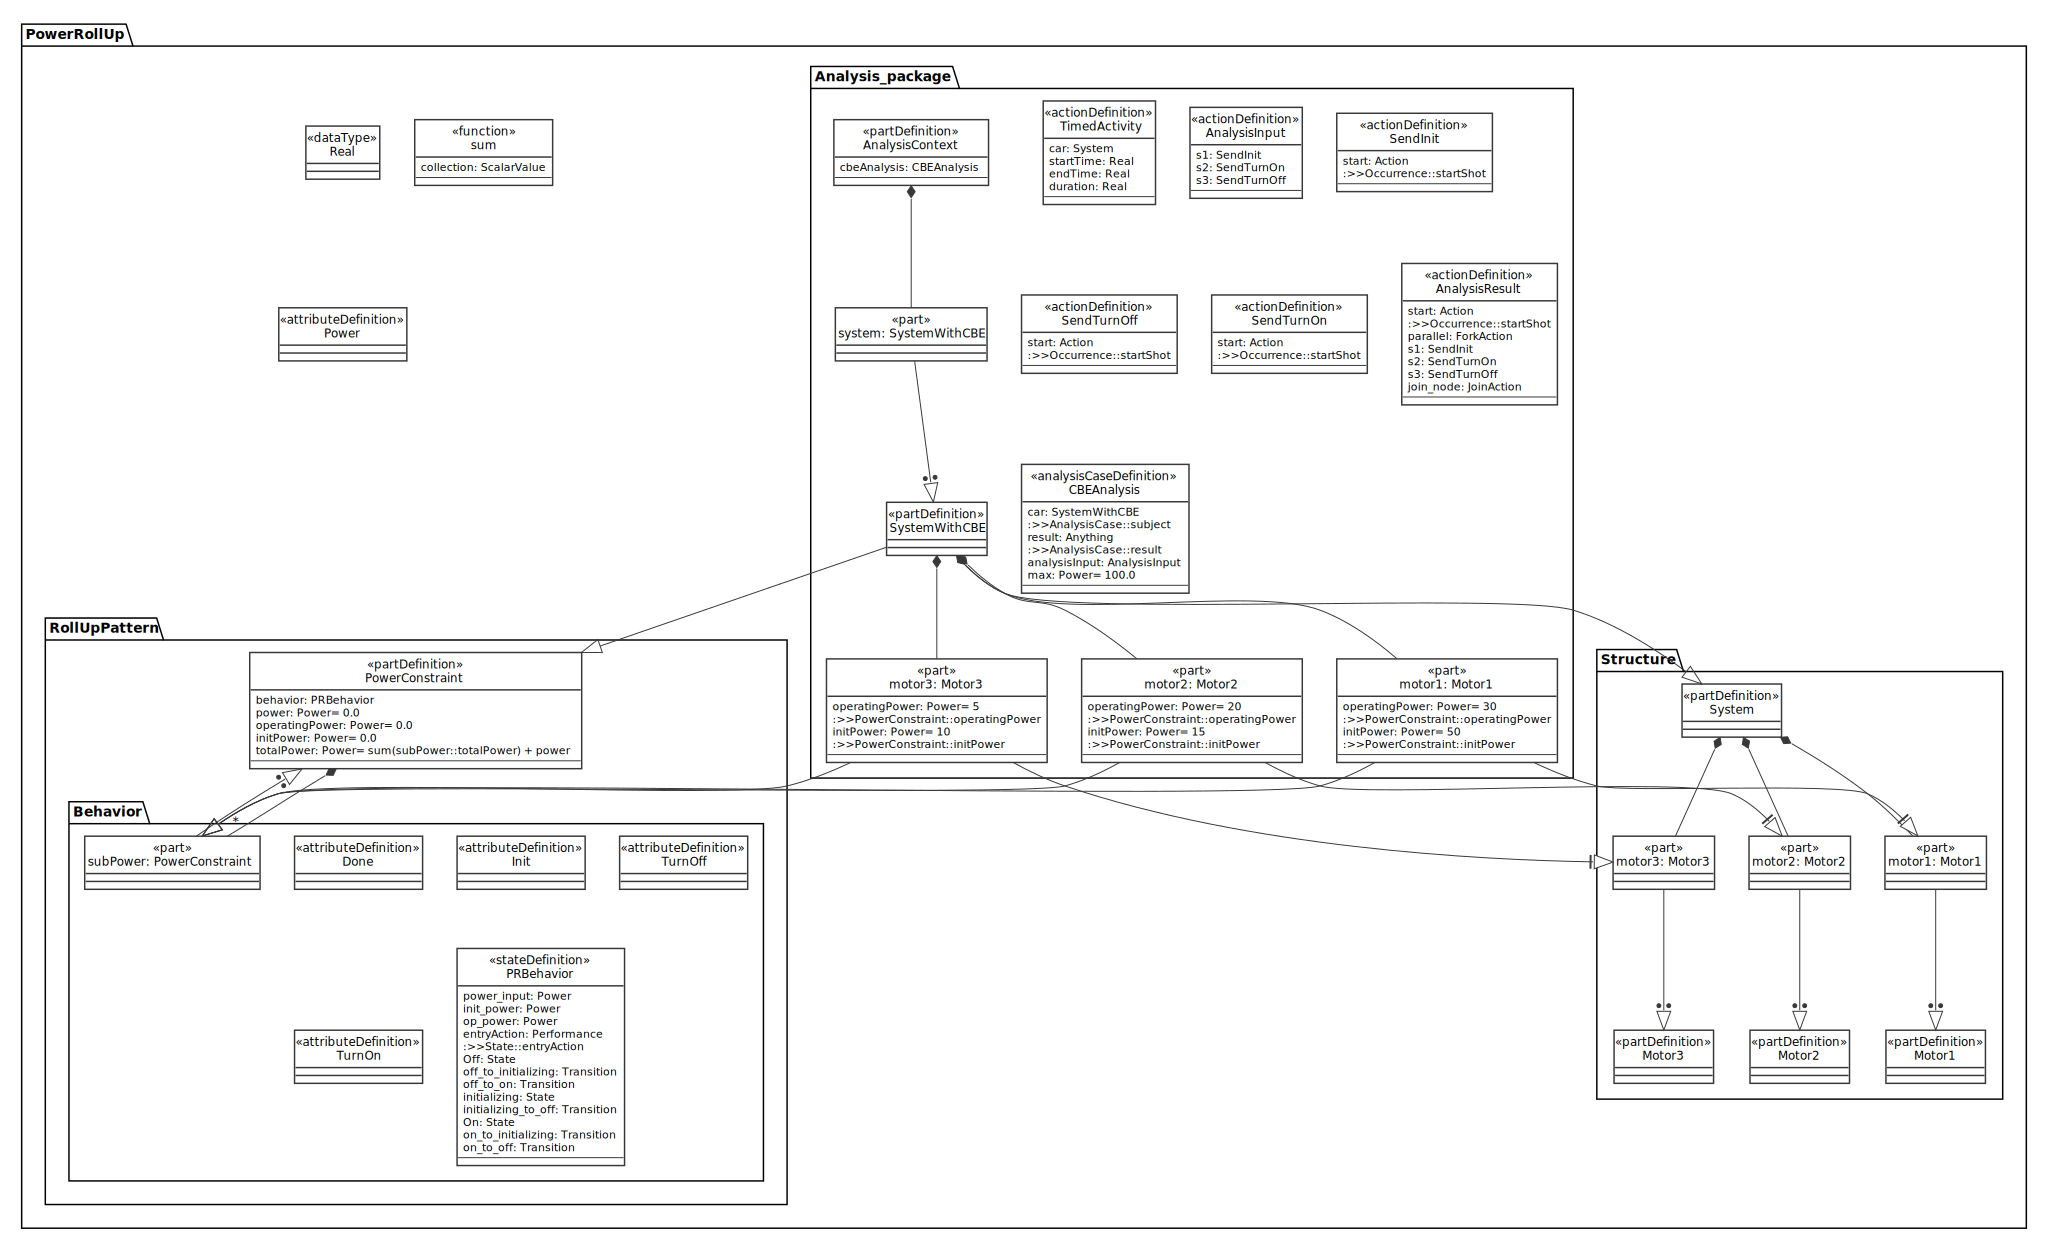

In [51]:
%viz --view=Default PowerRollUp